In [95]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

In [104]:
data = pd.read_csv('bio.csv')
data.dropna(inplace=True)
X = data[["Age","Gender","BMI","Body weight ","Height "]].values
y = data["Fasting GLU - PDL (Lab)"].values.reshape(-1, 1)

In [ ]:
#df = pd.read_csv('stuff copy.csv')

#X = df[['Age', 'Gender', 'BMI', 'Body weight ', 'Height ']].values
#y = df['HOMA-IR'].values.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
x_scaler = StandardScaler()
y_scaler = StandardScaler()
X_train_scaled = x_scaler.fit_transform(X_train)
X_test_scaled = x_scaler.transform(X_test)
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

<class 'numpy.ndarray'>


ValueError: could not convert string to float: 'F'

In [86]:
class RegressionNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(5, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
        )

    def forward(self, x):
        return self.model(x)

model = RegressionNN()
criterion = nn.HuberLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)

# Training loop
epochs = 2

Epoch [1/2], Loss: 0.4471, Val Loss: 0.4377
Epoch [2/2], Loss: 0.4319, Val Loss: 0.4322


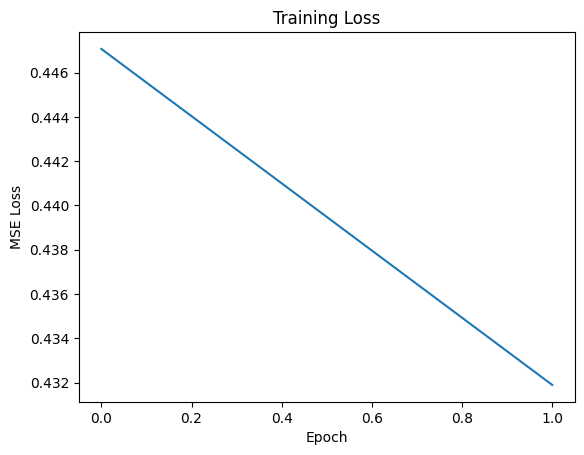

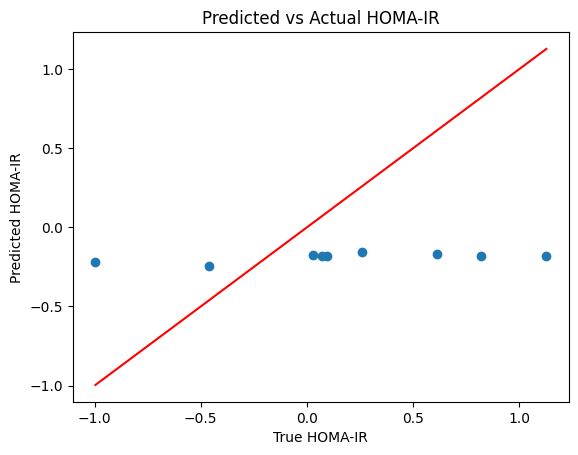

R² value: -0.2978


In [83]:
best_model_state = None

losses = []
val_losses = []
best_loss = float('inf')
patience = 20
trigger_times = 0
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    
    
    val_loss = criterion(model(X_test_tensor), y_test_tensor).item()
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}")
    if val_loss < best_loss:
        best_loss = val_loss
        best_model = model.state_dict()
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f"Early stopping at epoch {epoch}")
            model.load_state_dict(best_model)
            break
    


# Plot training loss
plt.plot(losses)
plt.plot(val_losses)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training Loss")
plt.show()

# Evaluate on test data
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor).numpy()
    predictions = y_scaler.inverse_transform(predictions)
    y_true = y_scaler.inverse_transform(y_test_tensor.numpy())

# Plot predictions vs actual
plt.scatter(y_true, predictions)
plt.xlabel("True HOMA-IR")
plt.ylabel("Predicted HOMA-IR")
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red')
plt.title("Predicted vs Actual HOMA-IR")
plt.show()

r2 = r2_score(y_true, predictions)
print(f"R² value: {r2:.4f}")

In [78]:
torch.save(best_model_state, 'model.pth')


In [79]:
model.load_state_dict(torch.load("model.pth"))
model.eval()


TypeError: Expected state_dict to be dict-like, got <class 'NoneType'>.